In [1]:
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
import numpy as np
from itertools import product
import pandas as pd
import os
import rasterio.warp as rasteriowarp
import time
from datetime import timedelta

In [2]:
SATELLITE_DATA_PATH = '/storage/data/eumetsat/native/reprojected2/'
PV_DATA_FILENAME = '~/data/pvoutput.org/UK_PV_timeseries_batch.nc'
PV_METADATA_FILENAME = '~/data/pvoutput.org/UK_PV_metadata.csv'

DST_CRS = {
    'ellps': 'WGS84',
    'proj': 'tmerc',  # Transverse Mercator
    'units': 'm'  # meters
}

# Geospatial boundary in Transverse Mercator (meters)
SOUTH = 5513500
NORTH = 6613500
WEST =  -889500
EAST =   410500

## Load and convert PV metadata

In [3]:
pv_metadata = pd.read_csv(PV_METADATA_FILENAME, index_col='system_id')
pv_metadata.dropna(subset=['longitude', 'latitude'], how='any', inplace=True)

In [4]:
# Convert lat lons to Transverse Mercator
pv_metadata['x'], pv_metadata['y'] = rasteriowarp.transform(
    src_crs={'init': 'EPSG:4326'},
    dst_crs=DST_CRS,
    xs=pv_metadata['longitude'].values,
    ys=pv_metadata['latitude'].values)

# Filter 3 PV systems which apparently aren't in the UK!
pv_metadata = pv_metadata[
    (pv_metadata.x >= WEST) &
    (pv_metadata.x <= EAST) &
    (pv_metadata.y <= NORTH) &
    (pv_metadata.y >= SOUTH)]

len(pv_metadata)

2548

## Load and normalise PV power data

In [5]:
%%time
pv_power = xr.load_dataset(PV_DATA_FILENAME)

CPU times: user 14.5 s, sys: 2.19 s, total: 16.7 s
Wall time: 16.8 s


In [6]:
pv_power_selected = pv_power.loc[dict(datetime=slice('2019-01-01', '2019-07-01'))]

In [7]:
pv_power_df = pv_power_selected.to_dataframe().dropna(axis='columns', how='all')
pv_power_df = pv_power_df.clip(lower=0, upper=5E7)
pv_power_df.columns = [np.int64(col) for col in pv_power_df.columns]
pv_power_df = pv_power_df.tz_localize('Europe/London').tz_convert('UTC')

In [8]:
del pv_power
del pv_power_selected

In [9]:
# A bit of hand-crafted cleaning
pv_power_df[30248][:'2019-01-03'] = np.NaN

In [10]:
# Scale to the range [0, 1]
pv_power_df -= pv_power_df.min()
pv_power_df /= pv_power_df.max()

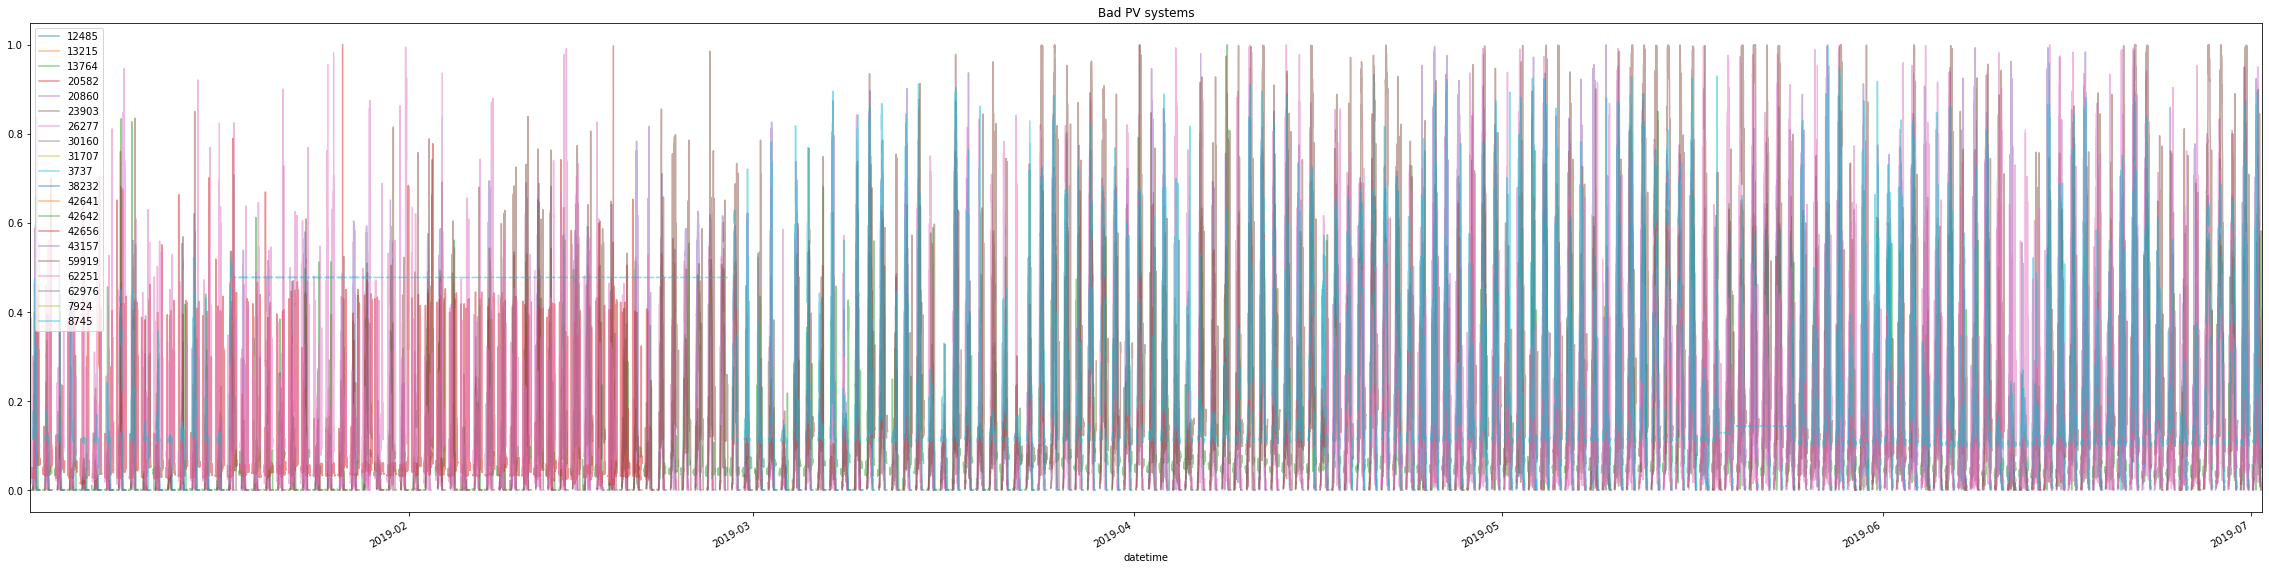

In [11]:
# Drop systems which are producing over night
NIGHT_YIELD_THRESHOLD = 0.4
night_hours = list(range(21, 24)) + list(range(0, 4))
bad_systems = np.where(
    (pv_power_df[pv_power_df.index.hour.isin(night_hours)] > NIGHT_YIELD_THRESHOLD).sum()
)[0]
bad_systems = pv_power_df.columns[bad_systems]
ax = pv_power_df[bad_systems].plot(figsize=(40, 10), alpha=0.5)
ax.set_title('Bad PV systems');

In [12]:
pv_power_df.drop(bad_systems, axis='columns', inplace=True)

In [13]:
%%time
# Interpolate
pv_power_df = pv_power_df.interpolate(limit=3)

CPU times: user 9.33 s, sys: 139 ms, total: 9.46 s
Wall time: 9.47 s


In [14]:
len(pv_power_df.columns)

864

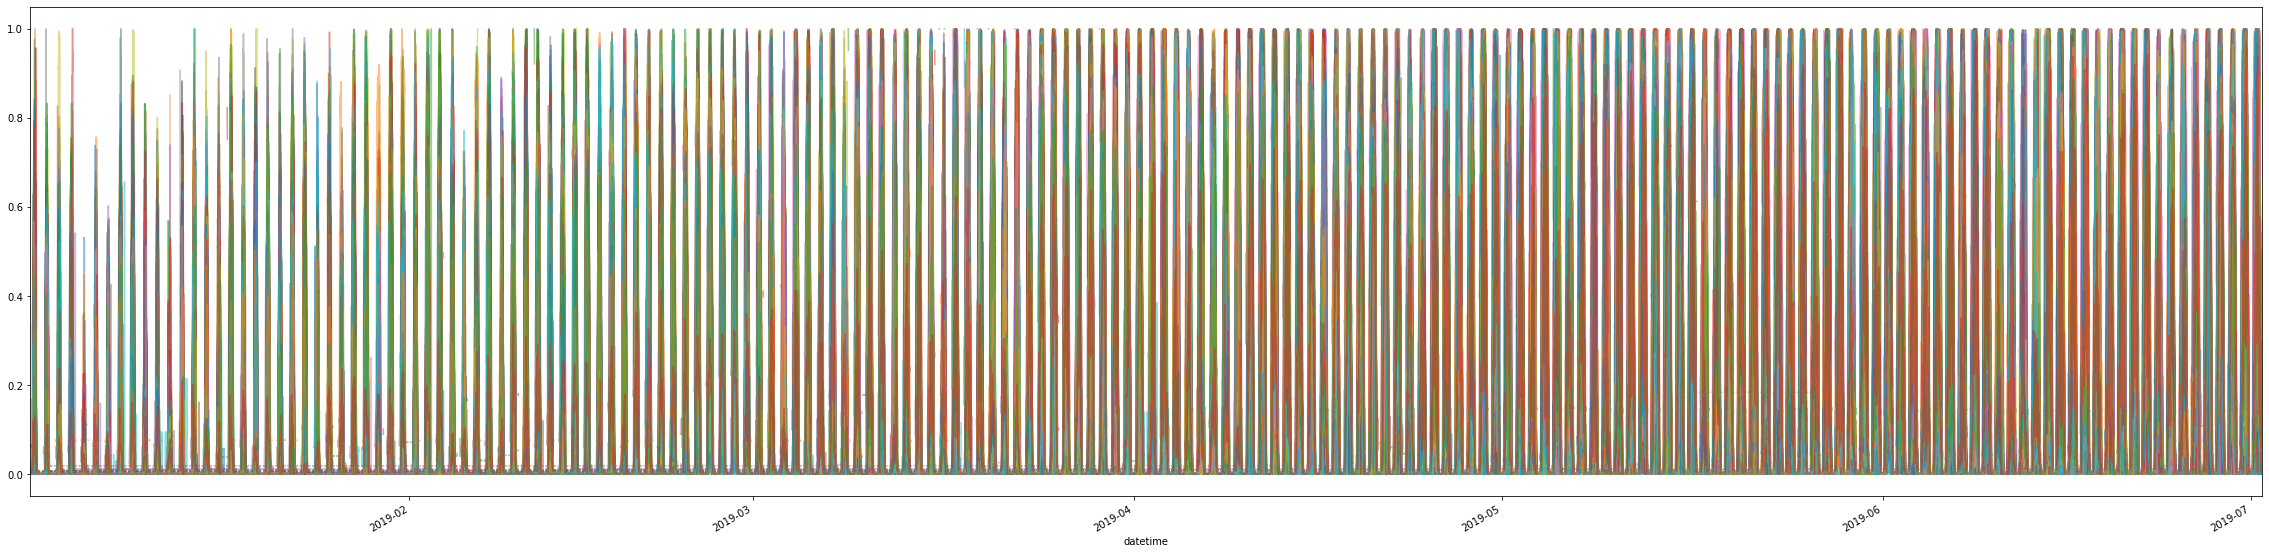

In [15]:
pv_power_df.plot(figsize=(40, 10), alpha=0.5, legend=False);

In [16]:
# Sort the metadata in the same order as the PV power data
pv_metadata = pv_metadata.reindex(pv_power_df.columns, axis='index')

## Load satellite data

In [17]:
%%time
#DATES = pd.date_range("2019-01-01", "2019-06-30", freq="D")
#HOURS = range(8, 17)
#satellite_data_filenames = [
#    os.path.join(SATELLITE_DATA_PATH, '{}T{:02d}.nc'.format(day.strftime('%Y-%m-%d'), hour))
#    for day, hour in list(product(DATES, HOURS))]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [19]:
%%time
satellite_data_filenames = os.path.join(SATELLITE_DATA_PATH, '2019-*.nc')
dataset = xr.open_mfdataset(paths=satellite_data_filenames, concat_dim='time')
da = dataset['HRV']

/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.7/site-packages/xarray/backends/api.py:931: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets a

CPU times: user 27.1 s, sys: 1.83 s, total: 29 s
Wall time: 2min 7s


In [20]:
def get_rectangle_of_satellite_data(time, centre_x, centre_y, width=128000, height=128000):
    half_width = width / 2
    half_height = height / 2
    
    north = centre_y + half_height
    south = centre_y - half_height
    east = centre_x + half_width
    west = centre_x - half_width
    
    data = da.loc[dict(
        time=time,
        x=slice(west, east), 
        y=slice(north, south))]
    
    MEAN = 20.444992
    STD = 8.766013
    data = data - MEAN
    data = data / STD 
    
    return data

In [21]:
# Test get rectangle
dt = pd.Timestamp('2019-03-30 09:00')
pv_system_id = pv_metadata.index[0]
x, y = pv_metadata.loc[pv_system_id][['x', 'y']]

In [22]:
%%time
sat_data = get_rectangle_of_satellite_data(time=dt, centre_x=x, centre_y=y, width=512000, height=512000)

CPU times: user 9.64 ms, sys: 0 ns, total: 9.64 ms
Wall time: 8.58 ms


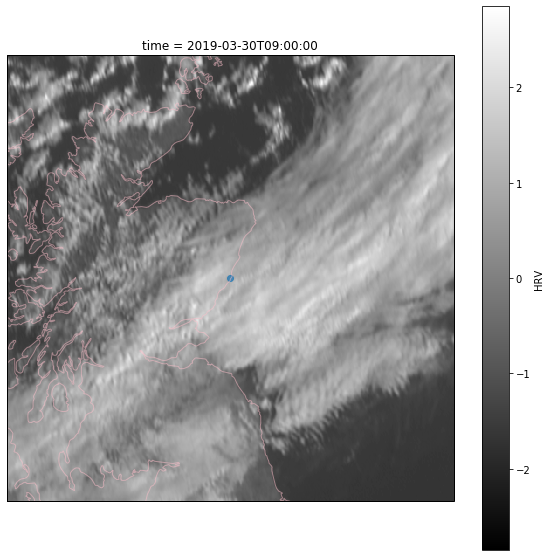

In [23]:
fig = plt.figure(figsize=(10, 10))
crs = ccrs.TransverseMercator()
ax = plt.axes(projection=crs)
ax.coastlines(resolution='10m', alpha=0.5, color='pink')

img = sat_data.plot.imshow(ax=ax, cmap='gray', origin='upper', add_colorbar=True)
path_collection = ax.scatter(x=x, y=y, alpha=0.7)

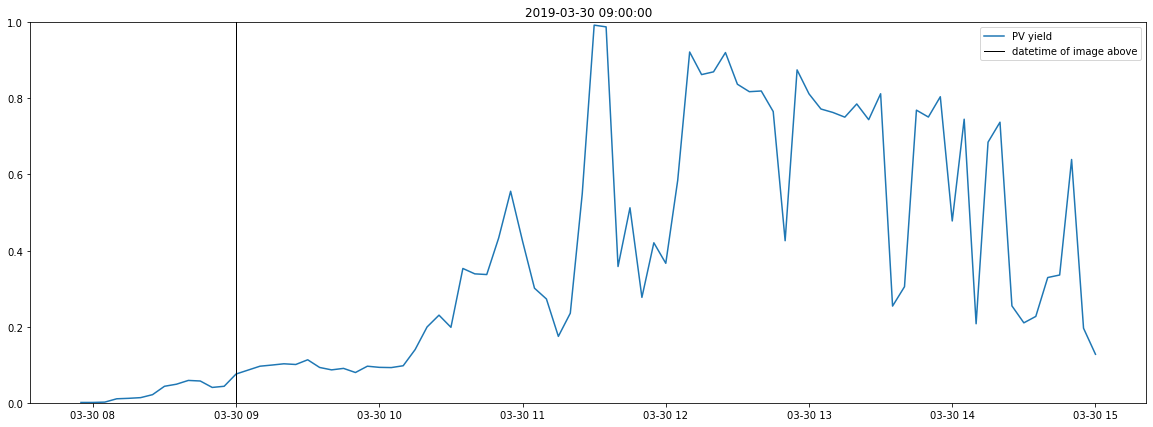

In [24]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.plot(
    pv_power_df[pv_system_id][dt - timedelta(hours=6):dt + timedelta(hours=6)], 
    label='PV yield')
ax.plot((dt, dt), (0, 1), linewidth=1, color='black', label='datetime of image above')
ax.legend()
ax.set_title(dt)
ax.set_ylim((0, 1));

In [ ]:
del sat_data

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [26]:
torch.cuda.get_device_name(0)

'GeForce RTX 2080 Ti'

In [85]:
np.random.randint?

Docstring:
randint(low, high=None, size=None, dtype='l')

Return random integers from `low` (inclusive) to `high` (exclusive).

Return random integers from the "discrete uniform" distribution of
the specified dtype in the "half-open" interval [`low`, `high`). If
`high` is None (the default), then results are from [0, `low`).

Parameters
----------
low : int or array-like of ints
    Lowest (signed) integers to be drawn from the distribution (unless
    ``high=None``, in which case this parameter is one above the
    *highest* such integer).
high : int or array-like of ints, optional
    If provided, one above the largest (signed) integer to be drawn
    from the distribution (see above for behavior if ``high=None``).
    If array-like, must contain integer values
size : int or tuple of ints, optional
    Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
    ``m * n * k`` samples are drawn.  Default is None, in which case a
    single value is returned.
dtype : dtype, opti

In [92]:
class PVDataset(Dataset):
    def __init__(self, train=False):
        self.pv_data = pv_power_df[pv_system_id].dropna()
        
        train_test_split = int(len(self.pv_data) / 5)
        if train:
            self.pv_data = self.pv_data.iloc[train_test_split:]
        else:
            self.pv_data = self.pv_data.iloc[:train_test_split]
        
        # Load satellite data into RAM
        start_date, end_date = self.pv_data.index[[0, -1]]
        
        self.sat_data = get_rectangle_of_satellite_data(
            time=slice(start_date, end_date), 
            centre_x=x, 
            centre_y=y)
        
        self.sat_data = self.sat_data.load()
        
        sat_data_index = pd.DatetimeIndex(self.sat_data.time.values, tz='UTC')
        self.datetime_index = self.pv_data.index.intersection(sat_data_index)

    def __len__(self):
        return len(self.datetime_index)
    
    def __getitem__(self, idx):
        dt = self.datetime_index[idx]
        pv_data = self.pv_data.loc[dt]
        sat_data = self.sat_data.sel(time=dt).values
        sat_data = sat_data[np.newaxis]
        pv_data = np.array([pv_data])
        
        if any(np.isnan(pv_data).flatten()) or any(np.isnan(sat_data).flatten()):
            print('NaNs detected!  Trying again!')
            return self.__getitem__(np.random.randint(low=0, high=len(self)-1))
        
        return torch.cuda.FloatTensor(sat_data), torch.cuda.FloatTensor(pv_data)

In [93]:
%%time
pv_dataset_test = PVDataset(train=False)
len(pv_dataset_test)

CPU times: user 6.32 s, sys: 1min 9s, total: 1min 16s
Wall time: 13min 26s


5465

In [94]:
%%time
pv_dataset_train = PVDataset(train=True)
len(pv_dataset_train)

CPU times: user 14 s, sys: 2min 46s, total: 3min
Wall time: 31min 26s


21535

In [95]:
%%time
sat_data, pv_data = pv_dataset_test[150]
print(sat_data.shape)
print(pv_data.shape)

torch.Size([1, 128, 128])
torch.Size([1])
CPU times: user 780 µs, sys: 17.4 ms, total: 18.2 ms
Wall time: 17.1 ms


In [96]:
dataloader = DataLoader(pv_dataset_train, batch_size=16, shuffle=True, drop_last=True)

In [97]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # x is now <batch_size>, 6, 62, 62.  
        # 62 is 124 / 2.  124 is the 128-dim input - 4
        x = self.pool(F.relu(self.conv2(x)))
        # x is now <batch_size>, 16, 29, 29
        x = x.view(-1, 16 * 29 * 29)
        # x is now <batch_size>, 16 x 29 x 29
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net().cuda()

In [98]:
optimizer = optim.SGD(net.parameters(), lr=0.01)
loss_func = nn.MSELoss()

In [99]:
STATS_PERIOD = 50

losses = []
n = len(dataloader)
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0

    t0 = time.time()
    for i_batch, (inputs, target) in enumerate(dataloader):
        print('\r Epoch:', epoch, 'Batch:', i_batch, 'of', n, end='', flush=True)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_func(outputs, target)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i_batch % STATS_PERIOD == STATS_PERIOD - 1:    # print every 2000 mini-batches
            t1 = time.time()
            mean_loss = running_loss / STATS_PERIOD
            losses.append(mean_loss)
            print('\n[%d, %5d] loss: %.3f; time= %.2f s' %
                  (epoch + 1, i_batch + 1, mean_loss, t1 - t0))
            running_loss = 0.0
            t0 = time.time()

print('Finished Training')

 Epoch: 0 Batch: 49 of 1345Batch: 21 of 1345 of 1345
[1,    50] loss: 0.070; time= 1.70 s
 Epoch: 0 Batch: 99 of 1345 0 Batch: 57 of 1345 1345 62 of 13450 Batch: 67 of 1345
[1,   100] loss: 0.047; time= 1.51 s
 Epoch: 0 Batch: 149 of 1345
[1,   150] loss: 0.037; time= 1.78 s
 Epoch: 0 Batch: 199 of 1345
[1,   200] loss: 0.039; time= 1.60 s
 Epoch: 0 Batch: 249 of 1345
[1,   250] loss: 0.038; time= 1.49 s
 Epoch: 0 Batch: 299 of 1345 1345
[1,   300] loss: 0.034; time= 1.55 s
 Epoch: 0 Batch: 349 of 1345 Batch: 335 of 1345
[1,   350] loss: 0.036; time= 1.78 s
 Epoch: 0 Batch: 399 of 1345of 1345376 of 1345
[1,   400] loss: 0.032; time= 1.60 s
 Epoch: 0 Batch: 449 of 1345
[1,   450] loss: 0.033; time= 1.65 s
 Epoch: 0 Batch: 499 of 1345 0 Batch: 459 of 1345
[1,   500] loss: 0.035; time= 1.85 s
 Epoch: 0 Batch: 543 of 1345NaNs detected!  Trying again!
 Epoch: 0 Batch: 549 of 1345
[1,   550] loss: 0.033; time= 1.72 s
 Epoch: 0 Batch: 599 of 1345
[1,   600] loss: 0.027; time= 1.58 s
 Epoch: 0

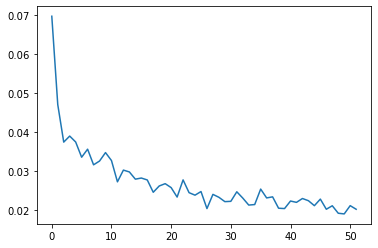

In [100]:
plt.plot(losses);

In [117]:
test_i = 0
for inputs, target in DataLoader(pv_dataset_test, batch_size=64, shuffle=False, drop_last=True):
    test_i += 1
    if test_i == 200:
        break

In [118]:
output = net(inputs)

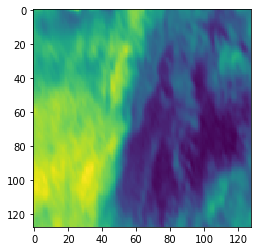

In [123]:
i = 30
plt.imshow(inputs[i, 0].cpu(), origin='upper')

In [124]:
output[i, 0].detach().cpu()

tensor(0.3801)

In [121]:
target[i, 0].detach().cpu()

tensor(0.1917)

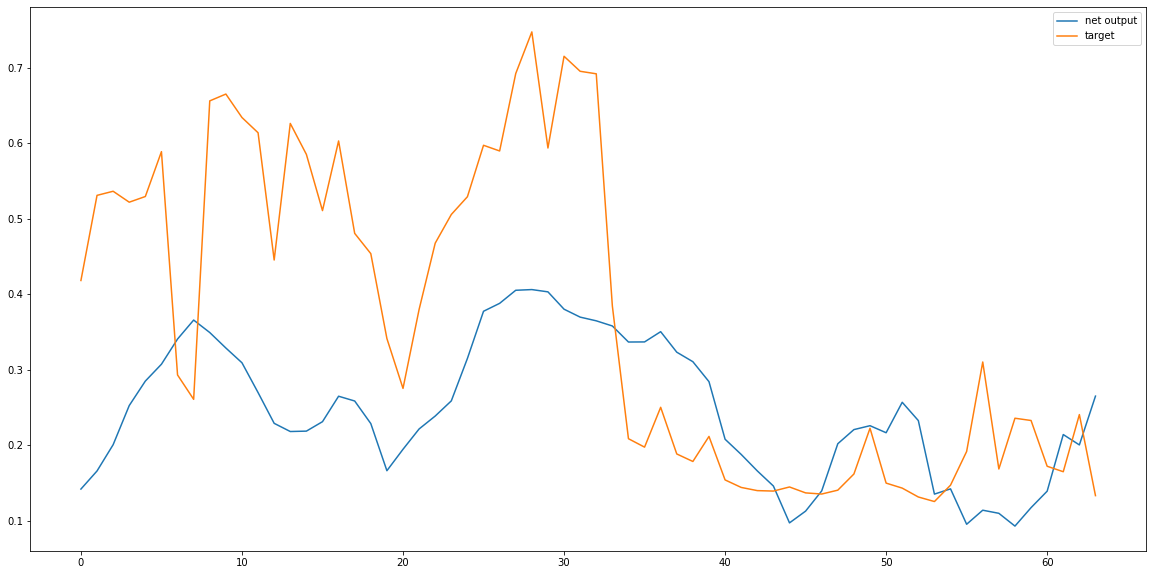

In [122]:
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(output[:, 0].detach().cpu(), label='net output')
ax.plot(target[:, 0].detach().cpu(), label='target')
ax.legend()